In [1]:
import git2repo
import pygit2
import re
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from datetime import datetime
import re, unicodedata
import nltk.corpus
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.stem import WordNetLemmatizer
from pygit2 import GIT_SORT_TOPOLOGICAL, GIT_SORT_REVERSE

In [2]:
repo_url = 'git://github.com/d3/d3.git'
repo_name = 'd3'

In [3]:
repo_obj = git2repo.git2repo(repo_url,repo_name)
repo = repo_obj.clone_repo()
commits = repo_obj.get_commit_objects()
commit_df = pd.DataFrame(commits, columns = ['commit_object'])
committed_files = repo_obj.get_committed_files()

2894


In [5]:
def get_diffs(self,commits):
        diffs = {}
        for i in range(len(commits)):
            t0 = self.repo.get(commits[i])
            files = {}
            if i != 0:
                t1 = t0.parents[0]
            else:
                continue
            _diff = self.repo.diff(t1,t0)
            for diff_i in _diff.__iter__():
                file_path = diff_i.delta.new_file.path
                old_lineno = []
                new_lineno = []
                for x in diff_i.hunks:
                    for y in x.lines:
                        old_lineno.append(y.old_lineno)
                        new_lineno.append(y.new_lineno)
                files[diff_i.delta.new_file.id] = {'file_path':file_path, 'old_lines':old_lineno,'new_lines':new_lineno}
            diffs[t0.id] = {'files':files,'object':t0}
        return diffs

In [6]:
commmit_id = []
for i in commits:
    commmit_id.append(i.id)
diffs = repo_obj.get_diffs(commmit_id)

In [7]:
bug_creator = []
count = 2
for value in diffs:
    _diff_files = diffs[value]['files']
    repo.head.set_target(diffs[value]['object'].parent_ids[0])
    for _value in _diff_files:
        try:
            file_path = _diff_files[_value]['file_path']
            blame = repo_obj.get_blame(file_path)
            for _line in _diff_files[_value]['old_lines']:
                if _line != -1:
                    ref = blame.for_line(_line)
                    bug_creator.append([ref.final_committer.name,diffs[value]['object'].committer.name ,ref.orig_commit_id, 1])
        except:
            continue

In [10]:
bug_creator_df = pd.DataFrame(bug_creator, columns = ['committer1','committer2','commit','count'])

In [11]:
bug_creator_df = bug_creator_df.drop(['commit'], axis = 1)
df = bug_creator_df.groupby( ['committer1','committer2']).count()
defect_count = []
for key,value in df.iterrows():
    user1 = key[0]
    user2 = key[1]
    count = value.values.tolist()[0]
    defect_count.append([user1,user2,count])

In [12]:
defect_count_df = pd.DataFrame(defect_count, columns = ['committer1','committer2', 'count'])

In [13]:
uniq_users1 = defect_count_df.committer1.unique()
uniq_users2 = defect_count_df.committer2.unique()
uniq_users = np.unique(np.concatenate((uniq_users1,uniq_users2)))

In [14]:
connection_matrix = np.ndarray(shape=(len(uniq_users),len(uniq_users)))
connection_matrix = np.zeros((len(uniq_users),len(uniq_users)), dtype=np.int)
user_dict = {}
rev_user_dict = {}
user_id = 0
for i in range(len(uniq_users)):
    user_dict[uniq_users[i]] = user_id
    rev_user_dict[user_id] = uniq_users[i]
    user_id += 1
for i in range(defect_count_df.shape[0]):
    changer = user_dict[defect_count_df.loc[i,'committer1']]
    changed = user_dict[defect_count_df.loc[i,'committer2']]
    connection_matrix[changer][changed] += defect_count_df.loc[i,'count']

In [21]:
%matplotlib inline
def show_graph_with_labels(matrix):
    gr = nx.Graph()
    rows,cols = np.where(matrix > 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    plt.figure(num=None, figsize = (50,50), dpi = 50, facecolor='w', edgecolor='k')
    nx.draw(gr, node_size=500)
    plt.show()
    return gr.degree(gr.nodes()),gr

C:\Program Files\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Program Files\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be re

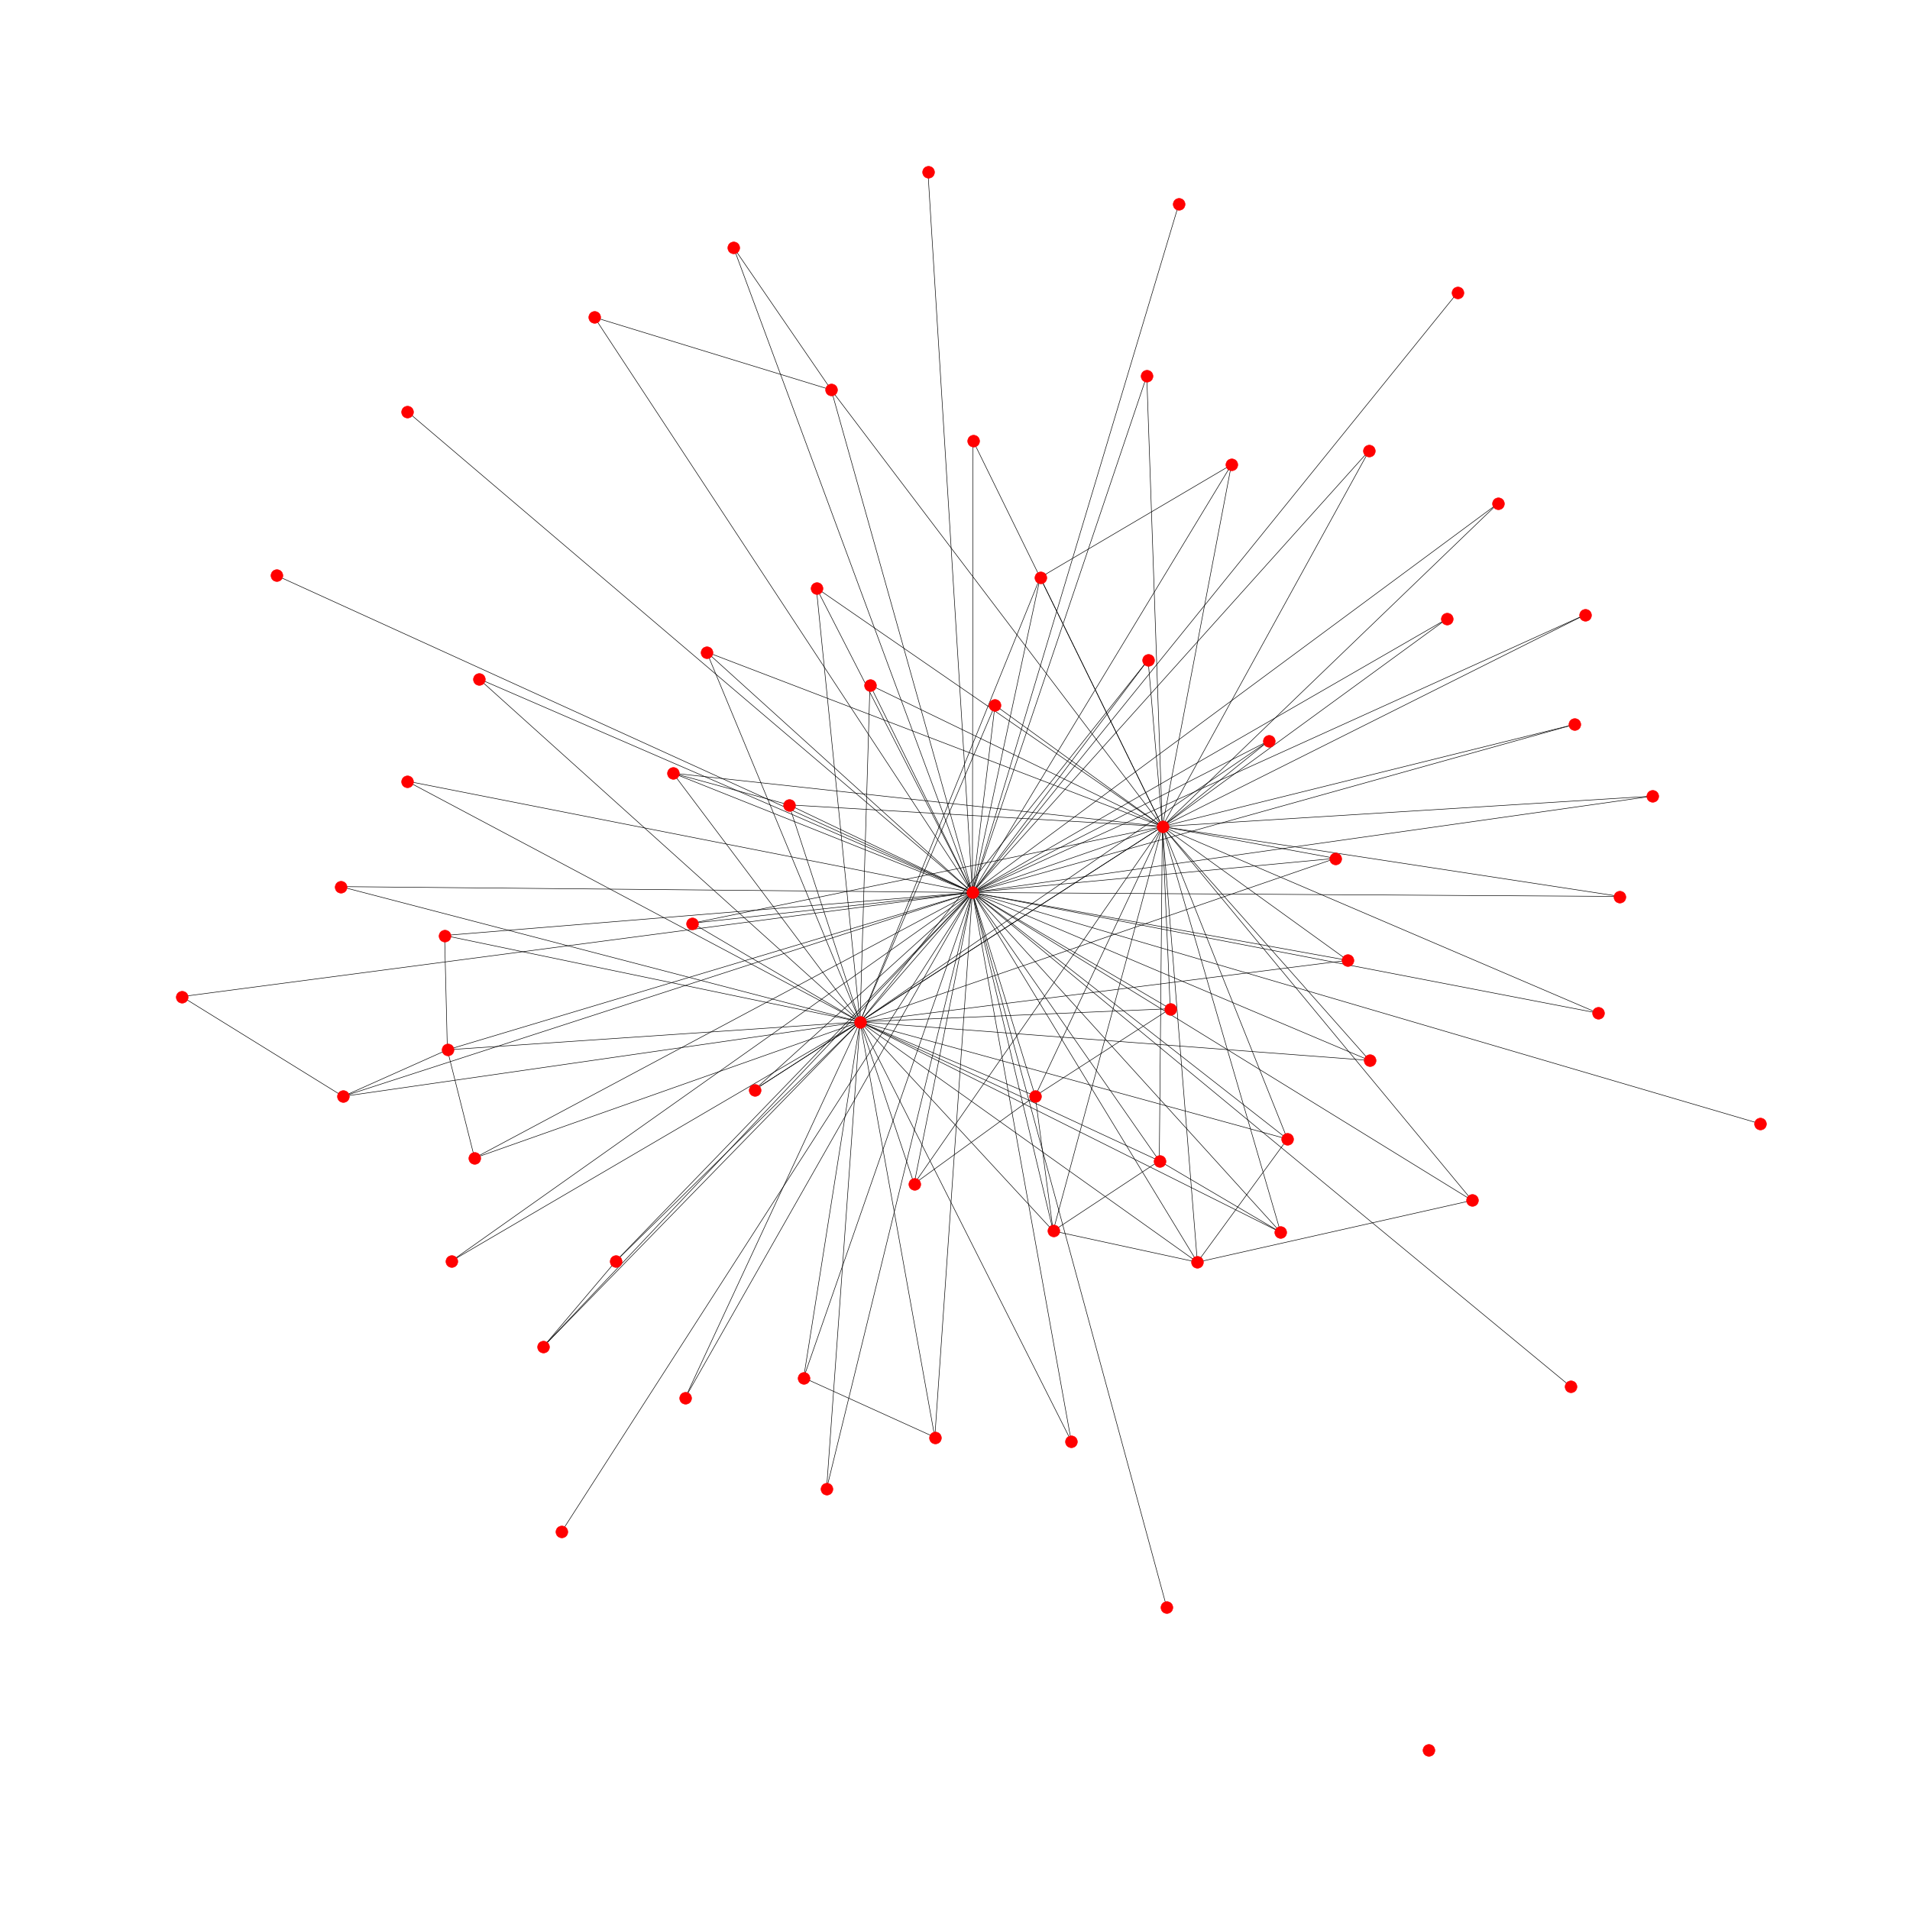

In [22]:
degree, G = show_graph_with_labels(connection_matrix)

In [23]:
user_degree = {}
for i in range(len(uniq_users)):
    user_name = uniq_users[i]
    user_id = user_dict[user_name]
    if user_id not in degree.keys():
        continue
    user_degree[user_name] = degree[user_id]

In [24]:
len(uniq_users)

66